# Title: Multilayer Perceptron MNIST
# Summary: A simple multilayer perceptron for MNIST

There is a 

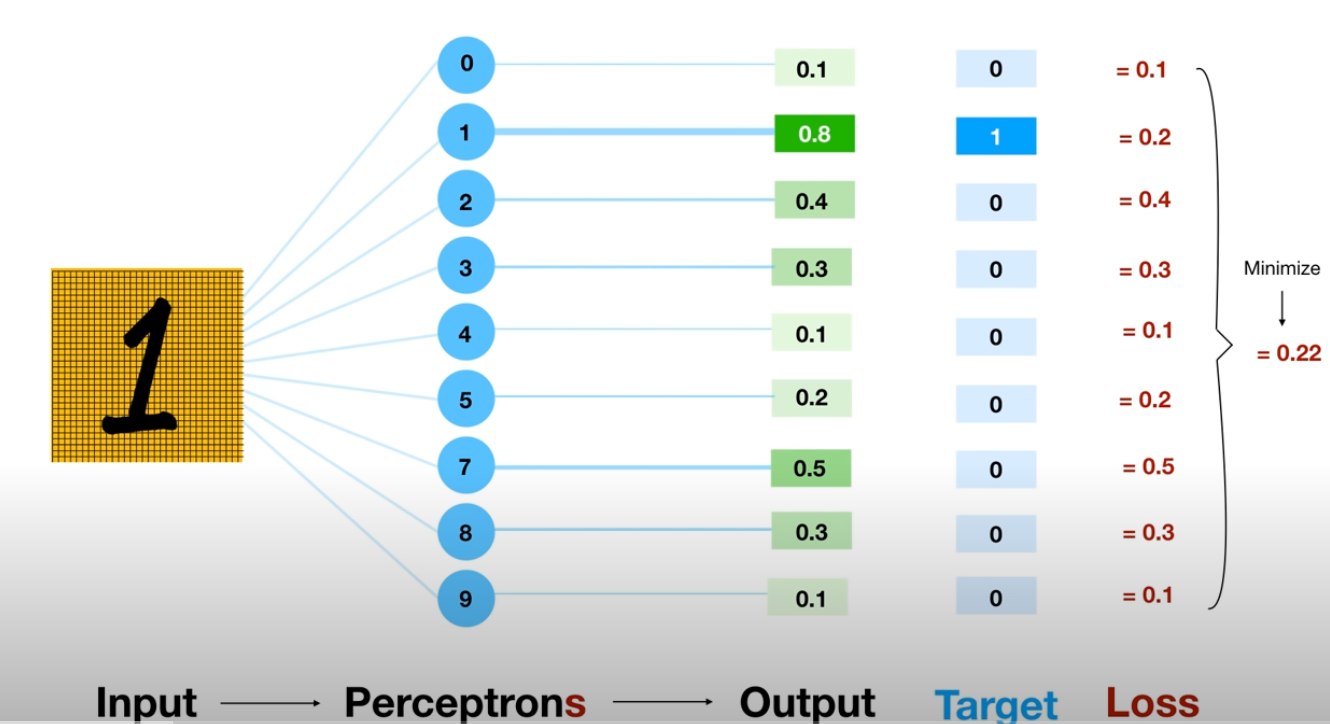

## One Hot Encoding
Summary: A method of representing categorical data as a binary vector
Here we're using it to represent the digits 0-9 as a vector of length 10. i.e - 1 = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 3 = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] etc

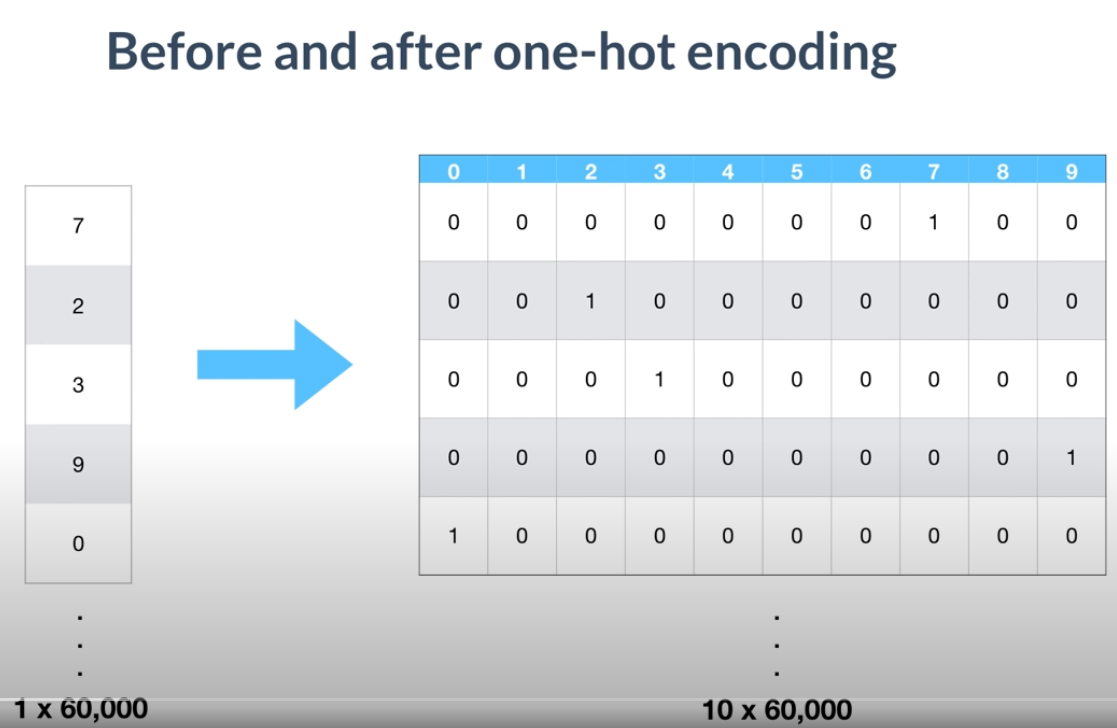

## Baseline
- Important to figure out what the baseline is for your problem
- Random accuracy would be ~10% (10 classes), so we should be able to do better than that

## Sigmoid
- Always want to use a softmax at the end of your network for classification to constrain the output to be between 0 and 1 and sum to 1

## Loss Functions really matter
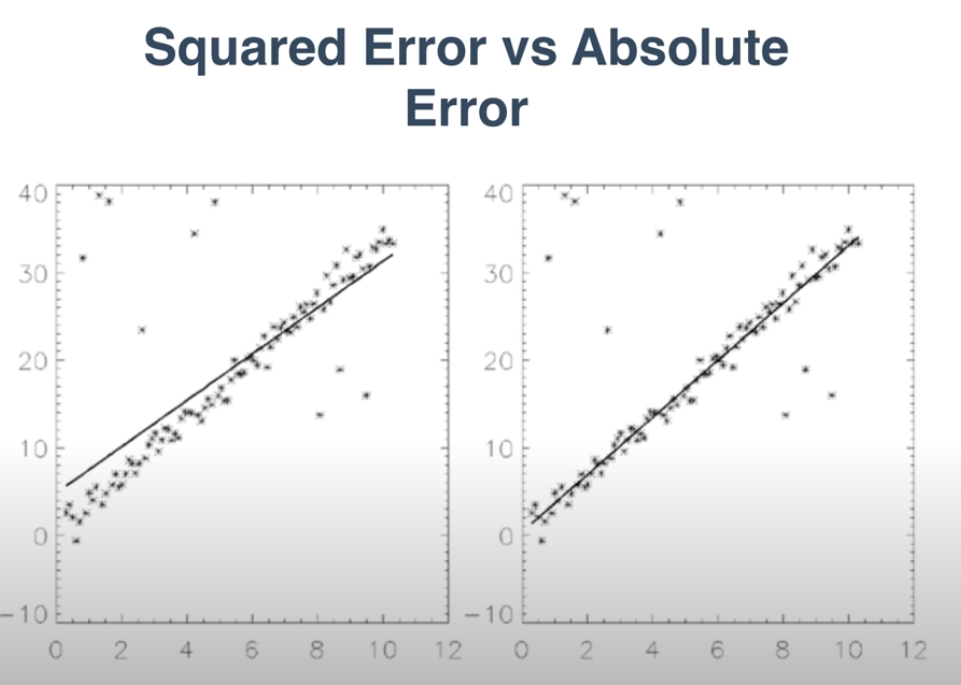
(On the left is MSE and on the right is Absolute Error)

- Mean Squared Error vs. Absolute Error:
  - MSE is more sensitive to outliers (as all values are squared), so it's better for regression problems
  - Absolute Error is more robust to outliers, so it's better for classification problems

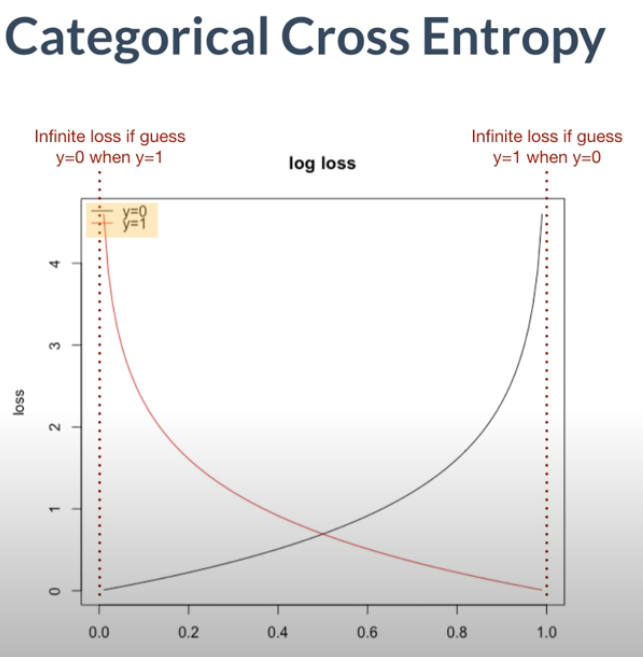
- **Categorical Cross Entropy** is the best loss function for classification problems
  - Makes Neural Networks output their true probability of an outcome
  - ie - if you're guess is 100% wrong (guessing 1 when answer is 0), the loss will be higher (near infinity), and if you're guess is 100% right, the loss will be lower (near 0)




# The Multilayer Perceptron

## Imports

In [15]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.callbacks import Callback
from random import randint
import json

from wandb.keras import WandbCallback
import wandb

# Set the notebook name for W&B
%env "WANDB_NOTEBOOK_NAME" "2-multilayer-perceptron-MNIST"
wandb.login()

env: "WANDB_NOTEBOOK_NAME"="2-multilayer-perceptron-MNIST"


True

In [42]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

# Model Config
config = dict()
config['epochs'] = 10
config['optimizer'] = "adam"
config['hidden_nodes'] = 100
config = dotdict(config)
print(config.hidden_nodes)

100


In [7]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
img_width = X_train.shape[1]
img_height = X_train.shape[2]

In [11]:
print("Input Date Shape:", X_train.shape)

Input Date Shape: (60000, 28, 28)


## Normalising the data
- We want to normalise the data so that it's between 0 and 1 (or -1 and 1)
  - This will make it easier for the network to learn
- Currently the data is 0 - 255 (8 bit colour), so we divide by 255 to get it between 0 and 1

In [8]:
# Normalise inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32') # Casting the data type to float32 as they start as int8
X_train /= 255.
X_test = X_test.astype('float32')
X_test /= 255.


In [26]:
print(X_train[0].shape)
print("A random row of pixels within the images:", X_train[randint(0,X_train.shape[0])][randint(0,28)])

(28, 28)
A random row of pixels within the images: [0.         0.         0.         0.         0.         0.
 0.         0.22745098 0.9882353  0.89411765 0.07058824 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [27]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
labels = range(10)

num_classes = y_train.shape[1]


In [34]:
print("Output Data Shape:", y_train.shape)
print("A random one-hot-encoded labeld:", y_train[randint(0,y_train.shape[0])])

Output Data Shape: (60000, 10)
A random one-hot-encoded labeld: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Middle Layer Perceptron (MLP) Activation Function: ReLU
The ReLU activation function is a very common activation function for hidden layers in neural networks. It is defined as:
- f(x) = max(0, x)
- i.e - if x is less than 0, return 0, otherwise return x
- It's really simple!

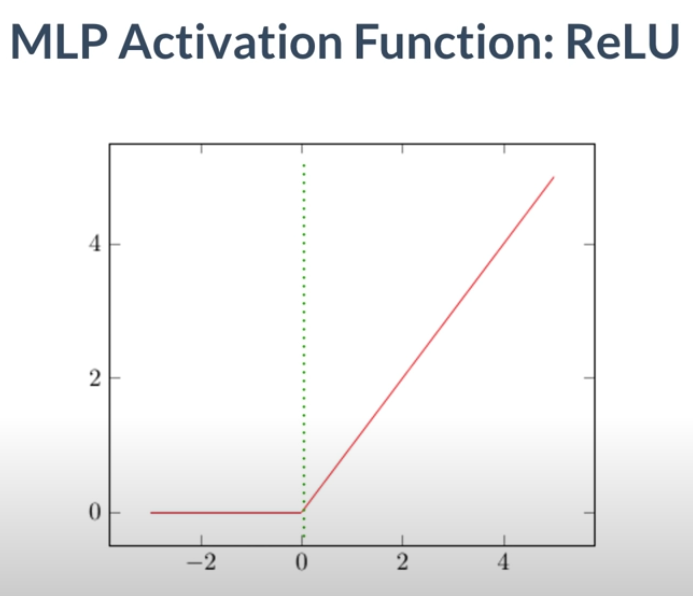


## Improverments over inital model
- **Normalised** input data - to help the model traing
- Set activation function to **softmax** - to ensure the output is a probability (0 - 1)
- Set the loss function to categorical cross entropy - to get the model to output the true probability of an outcome (ie - closer to 0 or 1 depending on the answer)
- Adding a hidden layer with **ReLU** activation function - to allow the model to learn more complex relationships
- Adding **Dropout** - to prevent overfitting

In [49]:
# create model
run = wandb.init(config=config)
model = Sequential()
model.add(Flatten(input_shape=(img_width, img_height)))
model.add(Dropout(0.2))
model.add(Dense(config.hidden_nodes, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=config.optimizer,
              metrics=['accuracy'])

# Summarising the model
- We can use the `summary()` function to get a summary of the model

We have
- 784 input neurons - our flattened layer - one for each pixel of the 28x28 image - no training parameters as they are always the same
- 78,530 trainable parameters (weights) in layer 1 - because we have 100 neurons and 784 inputs per neuron
- 1010 trainable parameters (weights) in layer 2 - because we have 10 neurons and 100 inputs per neuron

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=config.epochs,
          callbacks=[WandbCallback(data_type="image", labels=labels)])

run.finish()


Epoch 1/10


2023-01-31 19:04:47.530174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1874/1875 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.9043

2023-01-31 19:05:03.808441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 8ms/step


2023-01-31 19:05:06.020367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.3296 - accuracy: 0.9043 - val_loss: 0.1574 - val_accuracy: 0.9531
Epoch 2/10
2/2 [==============================] - 0s 3ms/step0s - loss: 0.1687 - accuracy: 0.94
INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.1687 - accuracy: 0.9499 - val_loss: 0.1124 - val_accuracy: 0.9663
Epoch 3/10
2/2 [==============================] - 0s 3ms/step0s - loss: 0.1315 - accuracy: 0.96
INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.1315 - accuracy: 0.9606 - val_loss: 0.0952 - val_accuracy: 0.9706
Epoch 4/10
2/2 [==============================] - 0s 3ms/step0s - loss: 0.1107 - accuracy: 0.96
INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.1106 - accuracy: 0.9662 - val_loss: 0.0890 - val_accuracy: 0.9720
Epoch 5/10
2/2 [==============================] - 0s 3ms/step0s - loss: 0.0990 - accuracy: 0.97
INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0989 - accuracy: 0.9703 - val_loss: 0.0798 - val_accuracy: 0.9758
Epoch 6/10
2/2 [==============================] - 0s 3ms/step0s - loss: 0.0885 - accuracy: 0.97
INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0885 - accuracy: 0.9724 - val_loss: 0.0748 - val_accuracy: 0.9781
Epoch 7/10
2/2 [==============================] - 0s 3ms/step0s - loss: 0.0831 - accuracy: 0.97
INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 10ms/step - loss: 0.0831 - accuracy: 0.9740 - val_loss: 0.0726 - val_accuracy: 0.9784
Epoch 8/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0732 - accuracy: 0.9762 - val_loss: 0.0770 - val_accuracy: 0.9769
Epoch 9/10
2/2 [==============================] - 0s 3ms/step0s - loss: 0.0704 - accuracy: 0.97
INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0704 - accuracy: 0.9775 - val_loss: 0.0724 - val_accuracy: 0.9772
Epoch 10/10
2/2 [==============================] - 0s 3ms/step0s - loss: 0.0670 - accuracy: 0.97
INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best/assets


wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230131_190435-ql9eusuw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.0669 - accuracy: 0.9789 - val_loss: 0.0668 - val_accuracy: 0.9800


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇██▇▇█
val_loss,█▅▃▃▂▂▁▂▁▁
accuracy,0.97892
best_epoch,9
best_val_loss,0.06684
epoch,9
loss,0.0669
val_accuracy,0.98


## Conclusion
How did the model do?
- Much more accurate: from 15% to 99.42% accuracy
- 97% validation accuracy: the `val_accuracy` is the accuracy on the validation set (the test set). This is the accuracy that we care about, as it's the accuracy on data that the model hasn't seen before.


The `val_loss` is the loss on the validation set (the test set). This is the loss that we care about, as it's the loss on data that the model hasn't seen before.

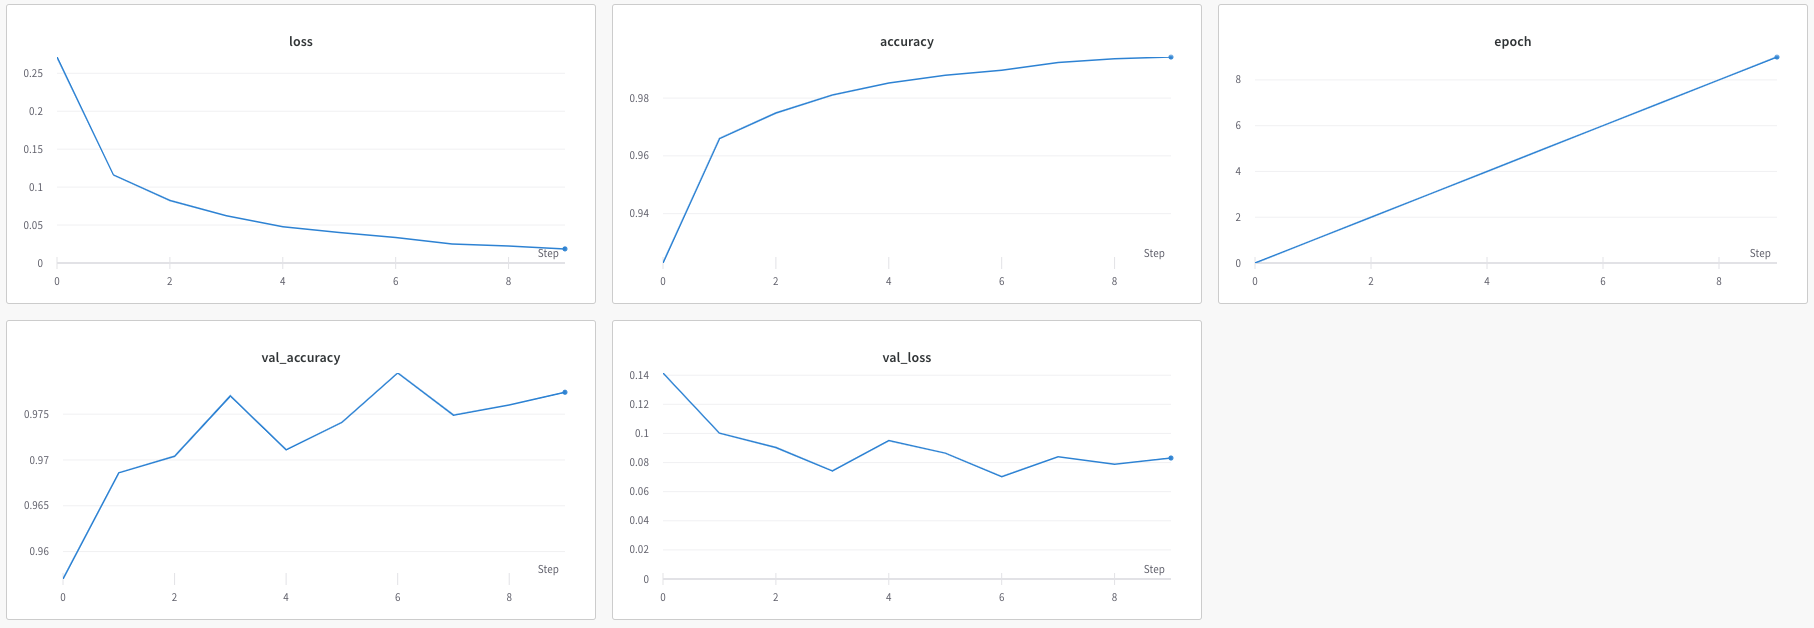


## With Dropout!
- With our dropout layers we get a validation accuracy of 98% and our model continued to improve from epoch to epoch!

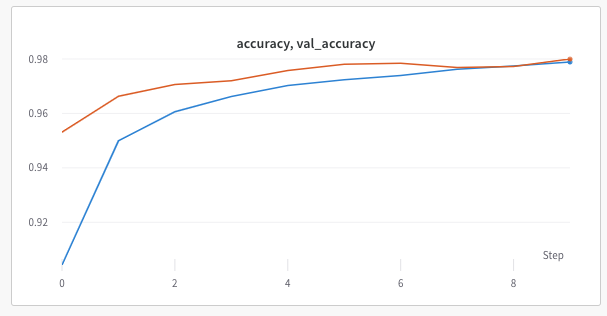

## How do you know if you are overfitting?
- If your training accuracy is much higher than your validation accuracy, you are overfitting!
  - i.e - we start overfitting here at epoch 3!
  - The more complex your models, the more likely they are to overfit

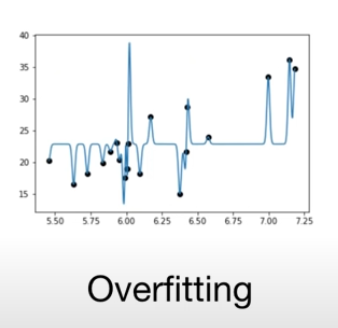
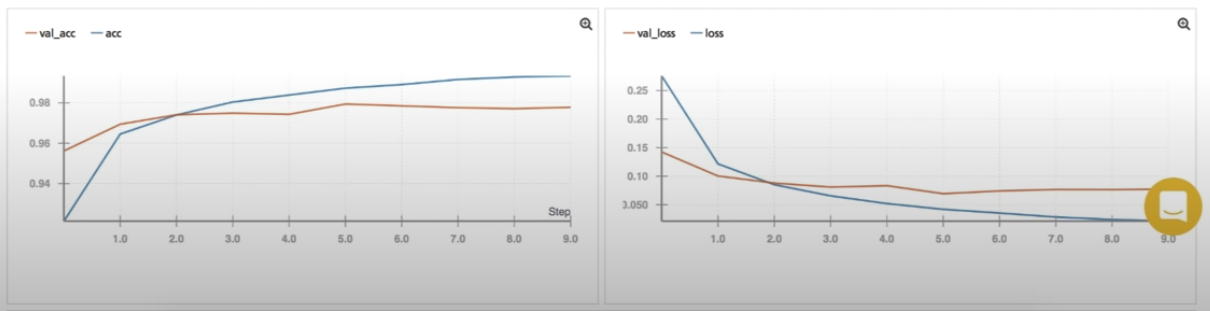

## Dropout helps prevent overfitting
- Dropout is a technique where randomly selected neurons are ignored during training
- Dropout sets a fraction of input in a layer to 0 at each update during training time
  - ie - Forces the network to learn more than one reason for classification
  - ie - Forces the network to learn more robust features that are useful in classifying the data
  - ie - Imagine a pixel in the top left was always a 7, then we remove this with dropout, the network will learn more robust representations of our 7 inputs

### When to use Dropout
- Dropout is most effective when you have a lot of data and a complex model
- Use dropout when your model is overfitting
- If you use dropout your model accuracy will initially be lower but will improve with more training

### Rule of thumb
- Start with 0.1 dropout and increase it if you are still overfitting?

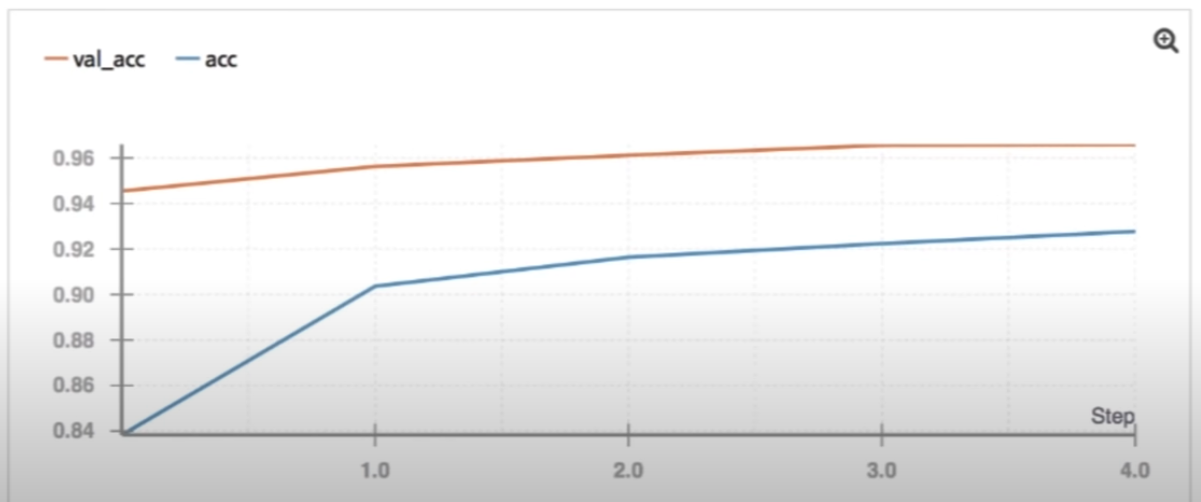
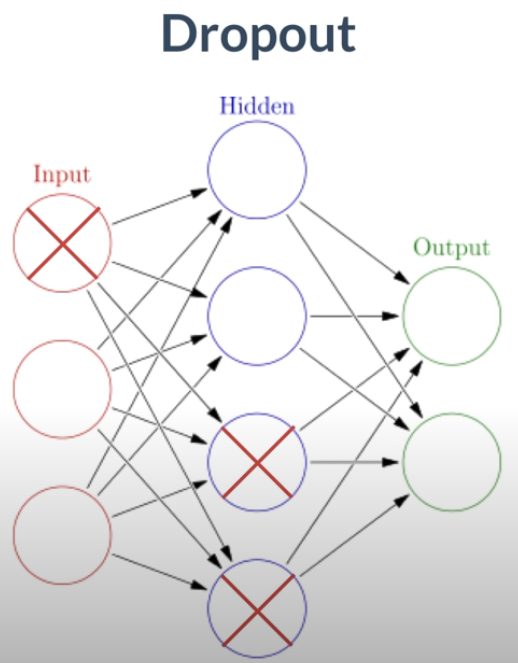
